In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [2]:
workspace_path = "hard_dataset/"

test_set = workspace_path + 'test/'
train_set = workspace_path + 'train/'
valid_set = workspace_path + 'Validation/'

In [3]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [4]:
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomAutocontrast(0.3),
                                       transforms.RandomAffine(5),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [5]:
train_data = datasets.ImageFolder(train_set, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_set, transform=valid_transforms)

train_load = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)#batch size değeri de değiştirilebilir
valid_load = torch.utils.data.DataLoader(valid_data, batch_size=4)

In [6]:
class_names = os.listdir(train_set)
train_images_count = {}
valid_images_count = {}
test_images_count = {}

for i in class_names:
    train_images_count[i] = len(os.listdir(os.path.join(train_set, i)))

for i in class_names:
    valid_images_count[i] = len(os.listdir(os.path.join(valid_set, i)))

print(f"TRAIN SET NUMBER: {train_images_count}")
print(f"VALIDATION SET NUMBER: {valid_images_count}")

TRAIN SET NUMBER: {'fake': 420, 'real': 353}
VALIDATION SET NUMBER: {'fake': 140, 'real': 117}


In [7]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
transforms.Normalize(mean=mean_nums, std=std_nums)

Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [8]:
def imshow(inp, size=(40,40), title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) #değerleri 0 ile 1 arasında sınırlar
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)

In [9]:
def visualize_model(model, testloader, device, class_names, num_images=9):
    was_training = model.training
    model.eval()
    images_handled = 0
    fig = plt.figure(figsize=(20, 20))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handled += 1
                ax = plt.subplot(num_images, 2, images_handled)
                ax.axis('off')
                ax.set_title('Actual: {} Predicted: {}'.format(class_names[labels[j].item()], class_names[preds[j].item()]))
                imshow(inputs.cpu().data[j], (8, 8))

                if images_handled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
egitimler = workspace_path + 'egitimler/'
mobileNetV3Sonuc = egitimler + 'MobileNetV3large/'

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [13]:
MobileNetV3 = models.mobilenet_v3_large(pretrained=True)
num_ftrs = MobileNetV3.classifier[3].in_features
MobileNetV3.classifier[3] = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MobileNetV3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(MobileNetV3.parameters(), lr=0.001, momentum=0.9)

epochs = 10
best_accuracy = 0.0
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0

    MobileNetV3.train()
    for data, target in train_load:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = MobileNetV3(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    MobileNetV3.eval()
    for data, target in valid_load:
        data, target = data.to(device), target.to(device)
        output = MobileNetV3(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)

        prob = torch.exp(output)
        top_p, top_class = prob.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    train_loss = train_loss / len(train_load.dataset)
    valid_loss = valid_loss / len(valid_load.dataset)
    accuracy = accuracy / len(valid_load)
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation Accuracy: {accuracy*100:.2f}%')

    if accuracy >= best_accuracy:
        print('Saving model with validation accuracy: {:.2f}%'.format(accuracy * 100))
        best_accuracy = accuracy
        torch.save(MobileNetV3.state_dict(), "C:/Users/myusu/OneDrive/Masaüstü/cnn_proje_3/egitimler/MobileNetV3large/best_mobilenetv3large_result.pth")

Epoch: 1 	Training Loss: 0.312492 	Validation Loss: 0.072811 	Validation Accuracy: 99.23%
Saving model with validation accuracy: 99.23%
Epoch: 2 	Training Loss: 0.177005 	Validation Loss: 0.069529 	Validation Accuracy: 98.85%
Epoch: 3 	Training Loss: 0.156251 	Validation Loss: 0.018001 	Validation Accuracy: 100.00%
Saving model with validation accuracy: 100.00%
Epoch: 4 	Training Loss: 0.120629 	Validation Loss: 0.031692 	Validation Accuracy: 99.23%
Epoch: 5 	Training Loss: 0.084357 	Validation Loss: 0.043504 	Validation Accuracy: 98.85%
Epoch: 6 	Training Loss: 0.088037 	Validation Loss: 0.060005 	Validation Accuracy: 98.85%
Epoch: 7 	Training Loss: 0.074553 	Validation Loss: 0.029916 	Validation Accuracy: 99.62%
Epoch: 8 	Training Loss: 0.062046 	Validation Loss: 0.034710 	Validation Accuracy: 98.85%
Epoch: 9 	Training Loss: 0.037022 	Validation Loss: 0.005925 	Validation Accuracy: 100.00%
Saving model with validation accuracy: 100.00%
Epoch: 10 	Training Loss: 0.064907 	Validation L

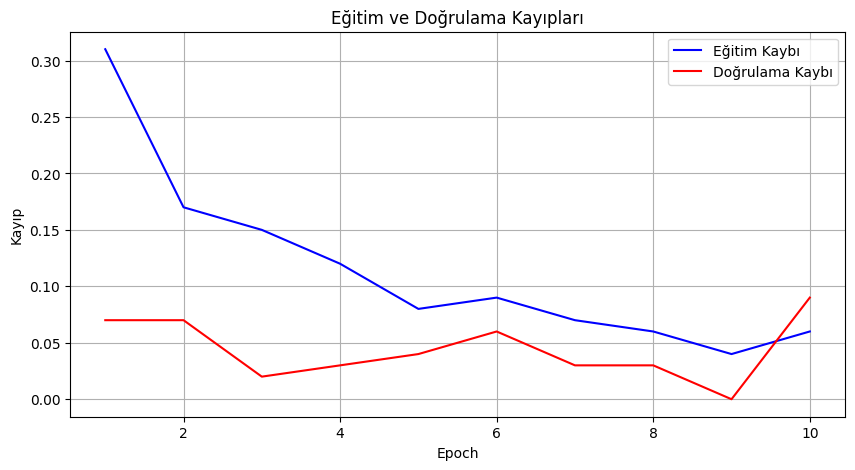

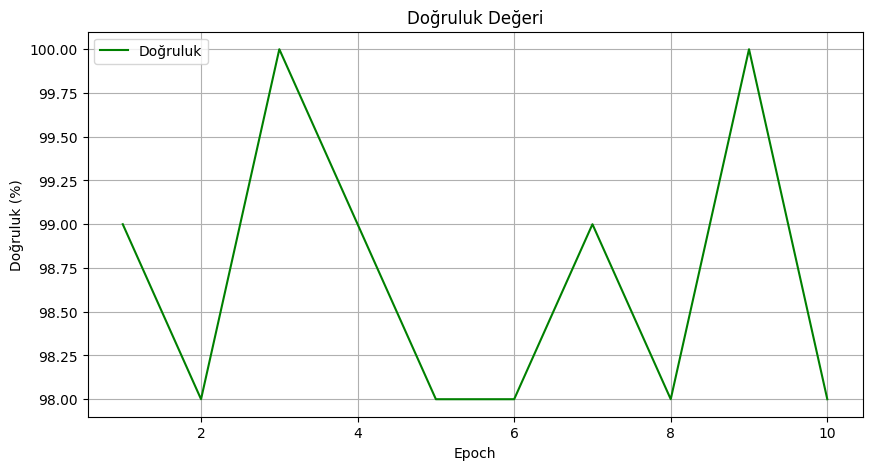

In [17]:
import matplotlib.pyplot as plt

train_losses = [0.31, 0.17, 0.15, 0.12, 0.08, 0.09, 0.07, 0.06, 0.04, 0.06] 
valid_losses = [0.07, 0.07, 0.02, 0.03, 0.04, 0.06, 0.03, 0.03, 0.00, 0.09]
accuracies = [99, 98, 100, 99, 98, 98, 99, 98, 100, 98]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Eğitim Kaybı')
plt.plot(epochs, valid_losses, 'r', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, 'g', label='Doğruluk')
plt.title('Doğruluk Değeri')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (%)')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
mobileNetV3smallSonuc = egitimler + 'MobileNetV3small/'

MobileNetV3small = models.mobilenet_v3_small(pretrained=True)
num_ftrs = MobileNetV3small.classifier[3].in_features
MobileNetV3small.classifier[3] = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MobileNetV3small.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(MobileNetV3small.parameters(), lr=0.001, momentum=0.9)

epochs = 10
best_accuracy = 0.0
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0

    MobileNetV3small.train()
    for data, target in train_load:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = MobileNetV3small(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    MobileNetV3small.eval()
    for data, target in valid_load:
        data, target = data.to(device), target.to(device)
        output = MobileNetV3small(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)

        prob = torch.exp(output)
        top_p, top_class = prob.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    train_loss = train_loss / len(train_load.dataset)
    valid_loss = valid_loss / len(valid_load.dataset)
    accuracy = accuracy / len(valid_load)
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation Accuracy: {accuracy*100:.2f}%')

    if accuracy >= best_accuracy:
        print('Saving model with validation accuracy: {:.2f}%'.format(accuracy * 100))
        best_accuracy = accuracy
        torch.save(MobileNetV3small.state_dict(), "C:/Users/myusu/OneDrive/Masaüstü/cnn_proje_3/egitimler/MobileNetV3small/best_mobilenetv3small_result.pth")

c:\Users\myusu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1 	Training Loss: 0.342074 	Validation Loss: 0.177878 	Validation Accuracy: 93.46%
Saving model with validation accuracy: 93.46%
Epoch: 2 	Training Loss: 0.203221 	Validation Loss: 0.046883 	Validation Accuracy: 99.23%
Saving model with validation accuracy: 99.23%
Epoch: 3 	Training Loss: 0.148159 	Validation Loss: 0.039354 	Validation Accuracy: 98.85%
Epoch: 4 	Training Loss: 0.112552 	Validation Loss: 0.030331 	Validation Accuracy: 100.00%
Saving model with validation accuracy: 100.00%
Epoch: 5 	Training Loss: 0.093503 	Validation Loss: 0.027559 	Validation Accuracy: 99.62%
Epoch: 6 	Training Loss: 0.063984 	Validation Loss: 0.014428 	Validation Accuracy: 100.00%
Saving model with validation accuracy: 100.00%
Epoch: 7 	Training Loss: 0.070156 	Validation Loss: 0.026964 	Validation Accuracy: 98.85%
Epoch: 8 	Training Loss: 0.055800 	Validation Loss: 0.029540 	Validation Accuracy: 98.85%
Epoch: 9 	Training Loss: 0.035889 	Validation Loss: 0.020805 	Validation Accuracy: 99.23%
Ep

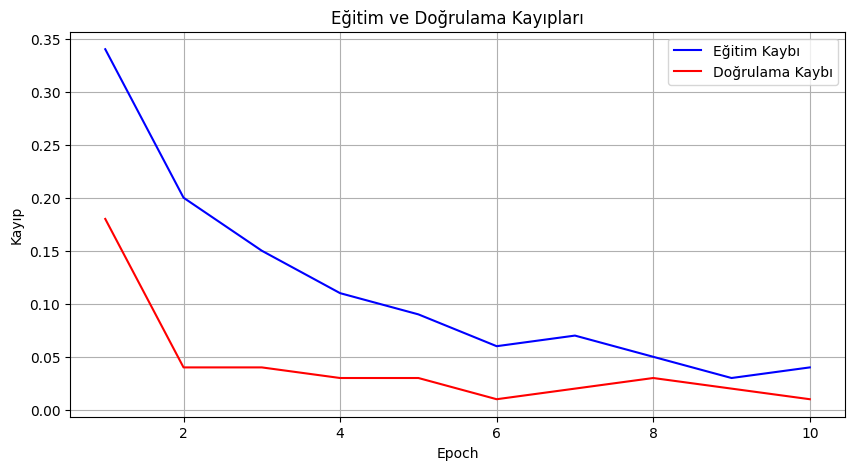

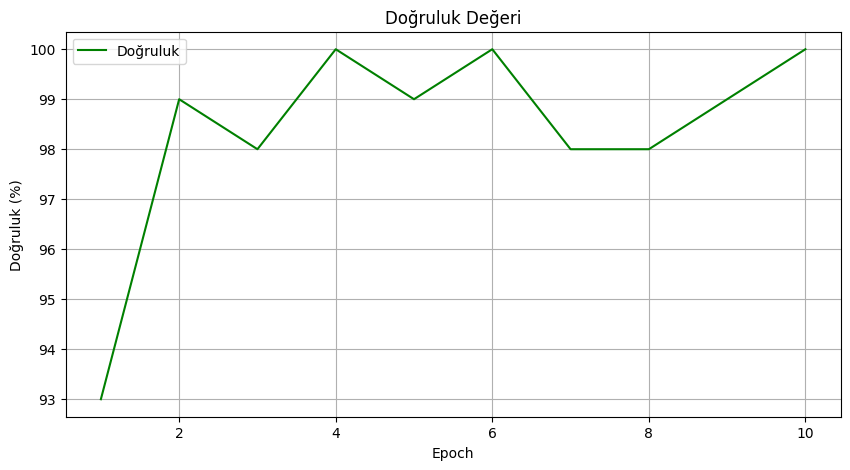

In [18]:
import matplotlib.pyplot as plt

train_losses = [0.34, 0.20, 0.15, 0.11, 0.09, 0.06, 0.07, 0.05, 0.03, 0.04] 
valid_losses = [0.18, 0.04, 0.04, 0.03, 0.03, 0.01, 0.02, 0.03, 0.02, 0.01]
accuracies = [93, 99, 98, 100, 99, 100, 98, 98, 99, 100]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Eğitim Kaybı')
plt.plot(epochs, valid_losses, 'r', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, 'g', label='Doğruluk')
plt.title('Doğruluk Değeri')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (%)')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
shuffleNetSonuc = egitimler + 'ShuffleNet/'

ShuffleNet = models.shufflenet_v2_x1_0(pretrained=True)
num_ftrs = ShuffleNet.fc.in_features
ShuffleNet.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ShuffleNet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ShuffleNet.parameters(), lr=0.01, momentum=0.9) #bütün başarı değerleri aynı çıktığı için 'learning rate' değiştim

epochs = 10
best_accuracy = 0.0
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0

    ShuffleNet.train()
    for data, target in train_load:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = ShuffleNet(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    ShuffleNet.eval()
    for data, target in valid_load:
        data, target = data.to(device), target.to(device)
        output = ShuffleNet(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)

        prob = torch.exp(output)
        top_p, top_class = prob.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    train_loss = train_loss / len(train_load.dataset)
    valid_loss = valid_loss / len(valid_load.dataset)
    accuracy = accuracy / len(valid_load)
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation Accuracy: {accuracy*100:.2f}%')

    if accuracy >= best_accuracy:
        print('Saving model with validation accuracy: {:.2f}%'.format(accuracy * 100))
        best_accuracy = accuracy
        torch.save(ShuffleNet.state_dict(), "C:/Users/myusu/OneDrive/Masaüstü/cnn_proje_3/egitimler/ShuffleNet/best_shufflenet_result.pth")

c:\Users\myusu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1 	Training Loss: 0.673476 	Validation Loss: 0.609100 	Validation Accuracy: 59.62%
Saving model with validation accuracy: 59.62%
Epoch: 2 	Training Loss: 0.439530 	Validation Loss: 0.085601 	Validation Accuracy: 100.00%
Saving model with validation accuracy: 100.00%
Epoch: 3 	Training Loss: 0.227471 	Validation Loss: 0.034814 	Validation Accuracy: 99.62%
Epoch: 4 	Training Loss: 0.163385 	Validation Loss: 0.012806 	Validation Accuracy: 100.00%
Saving model with validation accuracy: 100.00%
Epoch: 5 	Training Loss: 0.120111 	Validation Loss: 0.006750 	Validation Accuracy: 100.00%
Saving model with validation accuracy: 100.00%
Epoch: 6 	Training Loss: 0.159180 	Validation Loss: 0.012854 	Validation Accuracy: 100.00%
Saving model with validation accuracy: 100.00%
Epoch: 7 	Training Loss: 0.123356 	Validation Loss: 0.031984 	Validation Accuracy: 100.00%
Saving model with validation accuracy: 100.00%
Epoch: 8 	Training Loss: 0.061015 	Validation Loss: 0.007961 	Validation Accuracy: 1

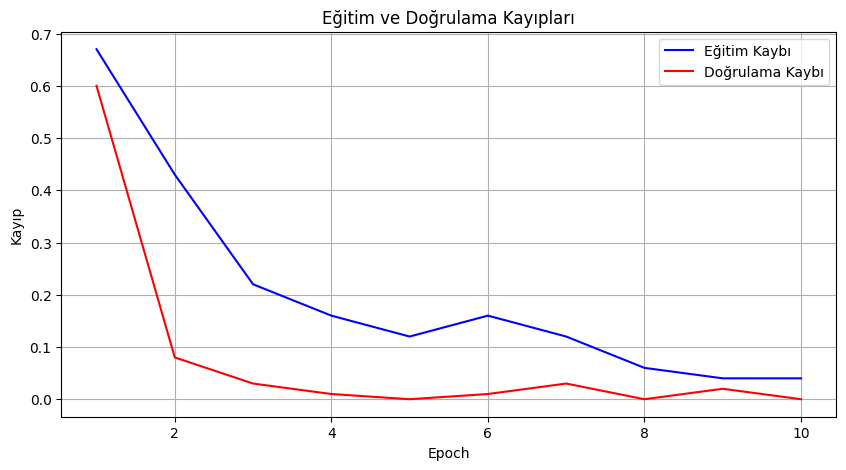

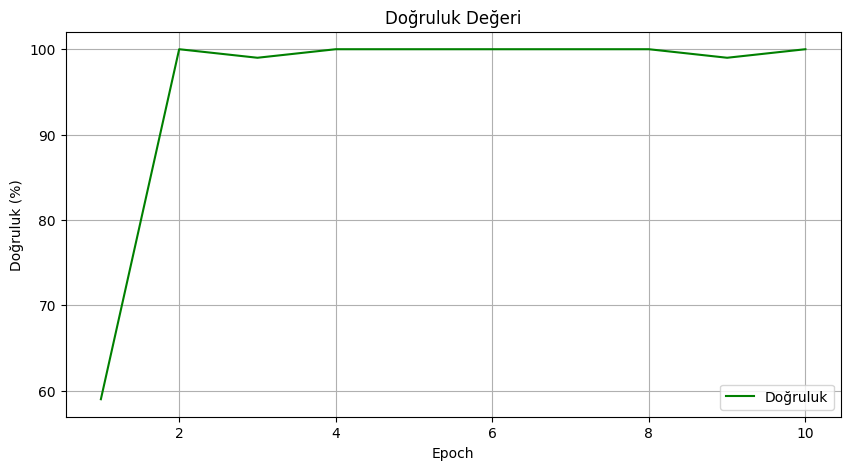

In [20]:
import matplotlib.pyplot as plt

train_losses = [0.67, 0.43, 0.22, 0.16, 0.12, 0.16, 0.12, 0.06, 0.04, 0.04] 
valid_losses = [0.60, 0.08, 0.03, 0.01, 0.00, 0.01, 0.03, 0.00, 0.02, 0.00]
accuracies = [59, 100, 99, 100, 100, 100, 100, 100, 99, 100]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Eğitim Kaybı')
plt.plot(epochs, valid_losses, 'r', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, 'g', label='Doğruluk')
plt.title('Doğruluk Değeri')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (%)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
SqueezeNetSonuc = egitimler + 'SqueezeNet/'

SqueezeNet = models.squeezenet1_0(pretrained=True)
SqueezeNet.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
SqueezeNet.num_classes = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SqueezeNet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(SqueezeNet.parameters(), lr=0.001, momentum=0.9)

epochs = 10
best_accuracy = 0.0
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0

    SqueezeNet.train()
    for data, target in train_load:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = SqueezeNet(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    SqueezeNet.eval()
    for data, target in valid_load:
        data, target = data.to(device), target.to(device)
        output = SqueezeNet(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)

        prob = torch.exp(output)
        top_p, top_class = prob.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    train_loss = train_loss / len(train_load.dataset)
    valid_loss = valid_loss / len(valid_load.dataset)
    accuracy = accuracy / len(valid_load)
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f} \tValidation Accuracy: {accuracy*100:.2f}%')

    if accuracy >= best_accuracy:
        print('Saving model with validation accuracy: {:.2f}%'.format(accuracy * 100))
        best_accuracy = accuracy
        torch.save(SqueezeNet.state_dict(), "C:/Users/myusu/OneDrive/Masaüstü/cnn_proje_3/egitimler/SqueezeNet/best_squeezenet_result.pth")

c:\Users\myusu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1 	Training Loss: 0.652892 	Validation Loss: 0.683994 	Validation Accuracy: 46.15%
Saving model with validation accuracy: 46.15%
Epoch: 2 	Training Loss: 0.608833 	Validation Loss: 0.489943 	Validation Accuracy: 80.00%
Saving model with validation accuracy: 80.00%
Epoch: 3 	Training Loss: 0.453221 	Validation Loss: 0.508269 	Validation Accuracy: 74.62%
Epoch: 4 	Training Loss: 0.344289 	Validation Loss: 0.173171 	Validation Accuracy: 95.00%
Saving model with validation accuracy: 95.00%
Epoch: 5 	Training Loss: 0.188985 	Validation Loss: 0.295318 	Validation Accuracy: 85.38%
Epoch: 6 	Training Loss: 0.128361 	Validation Loss: 0.152571 	Validation Accuracy: 94.23%
Epoch: 7 	Training Loss: 0.313102 	Validation Loss: 0.240621 	Validation Accuracy: 91.92%
Epoch: 8 	Training Loss: 0.149663 	Validation Loss: 0.179533 	Validation Accuracy: 94.62%
Epoch: 9 	Training Loss: 0.195202 	Validation Loss: 0.257012 	Validation Accuracy: 90.00%
Epoch: 10 	Training Loss: 0.146341 	Validation Loss:

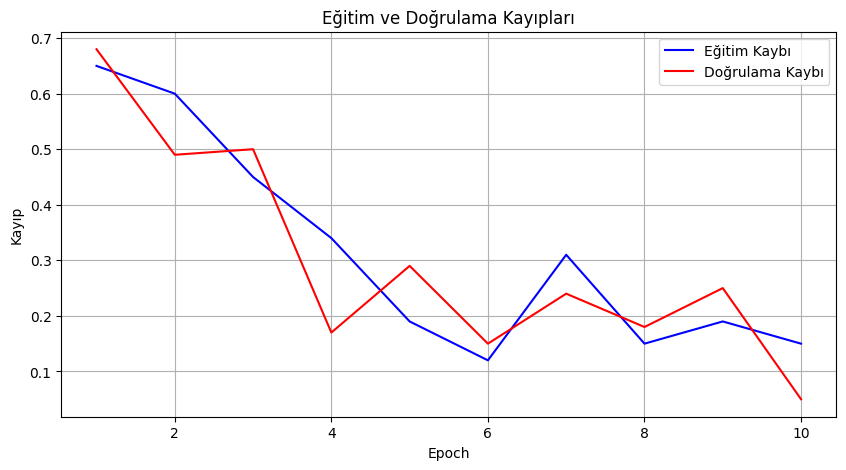

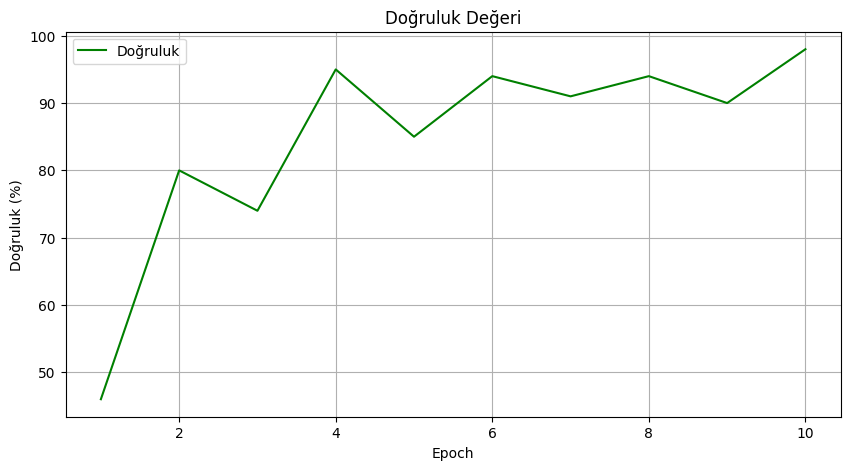

In [21]:
import matplotlib.pyplot as plt

train_losses = [0.65, 0.60, 0.45, 0.34, 0.19, 0.12, 0.31, 0.15, 0.19, 0.15] 
valid_losses = [0.68, 0.49, 0.50, 0.17, 0.29, 0.15, 0.24, 0.18, 0.25, 0.05]
accuracies = [46, 80, 74, 95, 85, 94, 91, 94, 90, 98]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Eğitim Kaybı')
plt.plot(epochs, valid_losses, 'r', label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, 'g', label='Doğruluk')
plt.title('Doğruluk Değeri')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (%)')
plt.legend()
plt.grid(True)
plt.show()